In [ ]:
# drive dosya erişim
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Kütüphanleri indir
#!pip install tensorflow
#!pip install keras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications.resnet50  import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping # metrik ve learning rate // en iyi ağırlık
from tensorflow.keras.applications import ResNet50
from keras.metrics import Precision, Recall
import numpy as np
from sklearn.metrics import recall_score, precision_score
from tensorflow.keras.regularizers import l2, l1 #L2 ve L1 düzgünleştirme, ağırlıkların büyüklüğünü sınırlama

In [ ]:
# Sınıflandırma
precision = Precision()
recall = Recall()

classes_names = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

In [ ]:
# Veri setinin yolu
train_data_dir = r"/content/drive/MyDrive/proje-b_dataset/train"
test_data_dir = r"/content/drive/MyDrive/proje-b_dataset/test"
valid_data_dir = r"/content/drive/MyDrive/proje-b_dataset/validation"

In [ ]:
# Veri ön işleme için ImageDataGenerator kullanma
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    shear_range=0.3, #açı aralığında rastgele kaydırır
    horizontal_flip=True,
    fill_mode='nearest', #boş piksel doldurma
    brightness_range=[0.2, 2.2], # Kontrast ve parlaklık ayarı
    width_shift_range=0.15,  # Yatay kaydırma
    height_shift_range=0.15,  # Dikey kaydırma
    zoom_range=0.1,  # Ölçeklendirme
    channel_shift_range=10.0  # Düşük yoğunluklu Gaussian gürültü
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [ ]:
# Veri setlerini yükleyerek ImageDataGenerator nesneleri oluşturma

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=128, #bir iterasyonda işlenecek resim sayısı
    class_mode='categorical',
    shuffle=True
)
#valid generator
validation_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

Found 1890 images belonging to 14 classes.
Found 420 images belonging to 14 classes.
Found 406 images belonging to 14 classes.


In [ ]:
#RESNET Model oluşturma
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Sadece eklenen katmanların eğitilmesini sağlama
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(len(classes_names), activation="softmax"))
print(model.summary())

94765736/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 4, 4, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [ ]:
# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

#Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)#egitim esnasinda ogrenme oranini dinamik olarak ayarlar

# Model Checkpoint
checkpoint = ModelCheckpoint('best_model_resnet_50.h5', verbose=1, save_best_only=True, monitor='val_loss')#model egitimi esnasinda en iyi genelleme yapan agirliklari kaydeder



In [ ]:
# Modeli eğitme
history = model.fit(
train_generator,
epochs=100,
validation_data=validation_generator,
batch_size=128,
callbacks=[reduce_lr, checkpoint],
shuffle=True
)


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 8.0495 - accuracy: 0.6815 - precision_1: 0.7178 - recall_1: 0.6783 
Epoch 1: val_loss improved from inf to 11.46224, saving model to best_model_resnet_50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 776s 51s/step - loss: 8.0495 - accuracy: 0.6815 - precision_1: 0.7178 - recall_1: 0.6783 - val_loss: 11.4622 - val_accuracy: 0.8238 - val_precision_1: 0.8238 - val_recall_1: 0.8238 - lr: 0.0100
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 5.8142 - accuracy: 0.8841 - precision_1: 0.8841 - recall_1: 0.8841
Epoch 2: val_loss did not improve from 11.46224
15/15 [==============================] - 189s 13s/step - loss: 5.8142 - accuracy: 0.8841 - precision_1: 0.8841 - recall_1: 0.8841 - val_loss: 12.8579 - val_accuracy: 0.8452 - val_precision_1: 0.8452 - val_recall_1: 0.8452 - lr: 0.0100
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 7.2051 - accuracy: 0.8783 - precision_1: 0.8783 - recall_1: 0.8783
Epoch 3: val_loss improved from 11.46224 to 6.77117, saving model to best_model_resnet_50.h5
15/15 [==============================] - 191s 13s/step - loss: 7.2051 - accuracy: 0.8783 - precision_1: 0.8783 - reca

In [ ]:
model.save_weights('best_model_resnet_50_new_data.h5')
model.load_weights("best_model_resnet_50_new_data.h5")

In [ ]:
# Model performansını değerlendirme
evaluation = model.evaluate((test_generator), steps=len(test_generator))
print("Test veri seti üzerinde modelin performansı: Loss={}, Accuracy={}, Precision={}, Recall={}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3]))


4/4 [==============================] - 80s 23s/step - loss: 1.4776 - accuracy: 0.9828 - precision_1: 0.9828 - recall_1: 0.9828
Test veri seti üzerinde modelin performansı: Loss=1.477612853050232, Accuracy=0.982758641242981, Precision=0.982758641242981, Recall=0.982758641242981


dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'lr'])


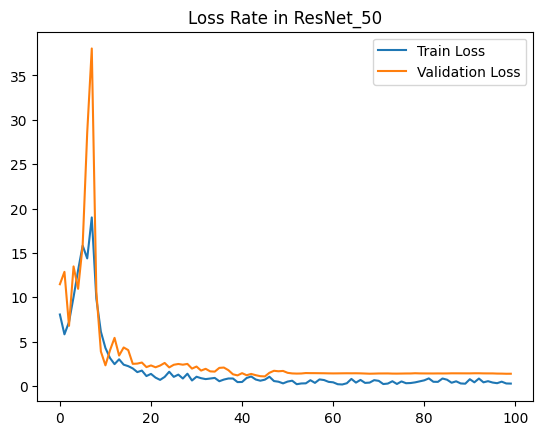

In [ ]:
#GÖRSELLEŞTİRME
import matplotlib.pyplot as plt
print(history.history.keys())
plt.title("Loss Rate in ResNet_50")
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

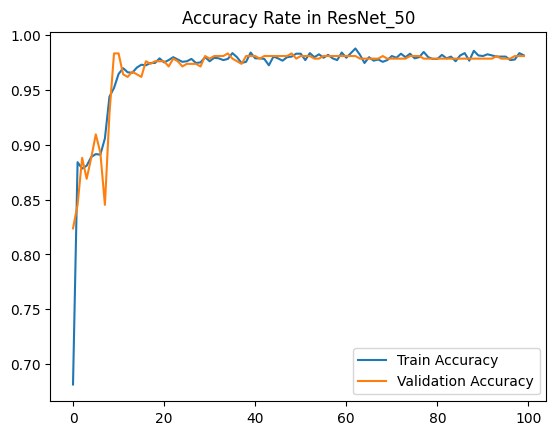

In [ ]:
plt.figure()
plt.title("Accuracy Rate in ResNet_50")
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

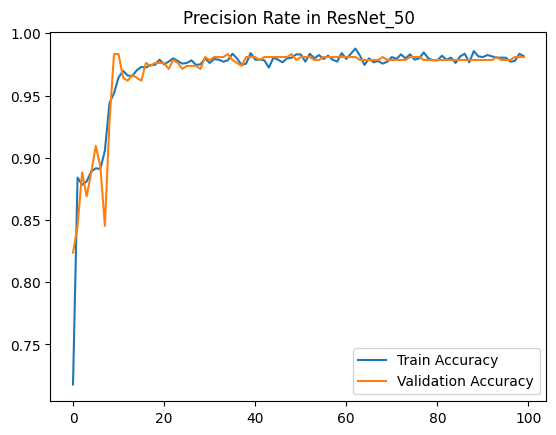

In [ ]:
plt.figure()
plt.title("Precision Rate in ResNet_50")
plt.plot(history.history["precision_1"], label = "Train Accuracy")
plt.plot(history.history["val_precision_1"], label = "Validation Accuracy")
plt.legend()
plt.show()

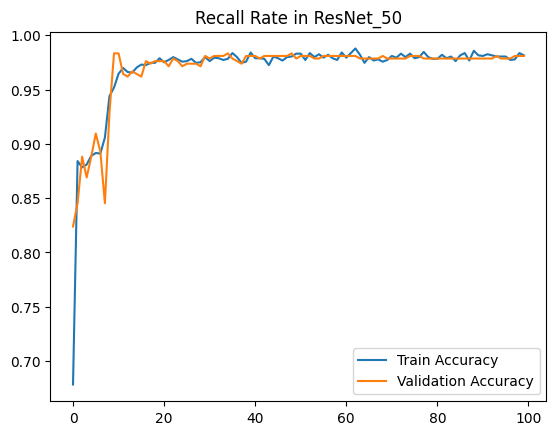

In [ ]:
plt.figure()
plt.title("Recall Rate in ResNet_50")
plt.plot(history.history["recall_1"], label = "Train Accuracy")
plt.plot(history.history["val_recall_1"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
#TAHMİN
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50  import preprocess_input

classes_names = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

#onceden egitilen modeli yukleme
model = load_model('best_model_resnet_50.h5')

#goruntuyu okuma ve veri on isleme yapma
img_path = r"/content/B.png"  # Test resminin yolu
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Tahmin yapma
predictions = model.predict(x)#tahminde bulunma
predicted_class_index = np.argmax(predictions)
predicted_class = classes_names[predicted_class_index]

print("Tahmin edilen sınıf:", predicted_class)


1/1 [==============================] - 1s 1s/step
Tahmin edilen sınıf: azami_hiz_70
